### Loading modules

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn import datasets
import sklearn
import pprint
import plotly.express as px
import scipy

### Set the parameters of matplotlib

In [3]:
matplotlib.rcParams['font.size'] = 16
plt.style.use('default')

### Load dataset

In [4]:
dataset = datasets.load_iris()

In [5]:
for elem in dataset.keys():
    print(elem, type(dataset[elem]))

data <class 'numpy.ndarray'>
target <class 'numpy.ndarray'>
frame <class 'NoneType'>
target_names <class 'numpy.ndarray'>
DESCR <class 'str'>
feature_names <class 'list'>
filename <class 'str'>
data_module <class 'str'>


In [6]:
ext_target = dataset.target[:, None]
df = pd.DataFrame(np.concatenate((dataset.data, ext_target, dataset.target_names[ext_target]), axis=1), columns=dataset.feature_names + ['ext_target', 'target_names'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),ext_target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [7]:
features = dataset.data
target = dataset.target
print(features.shape, target.shape)

(150, 4) (150,)


### Visualise dataset

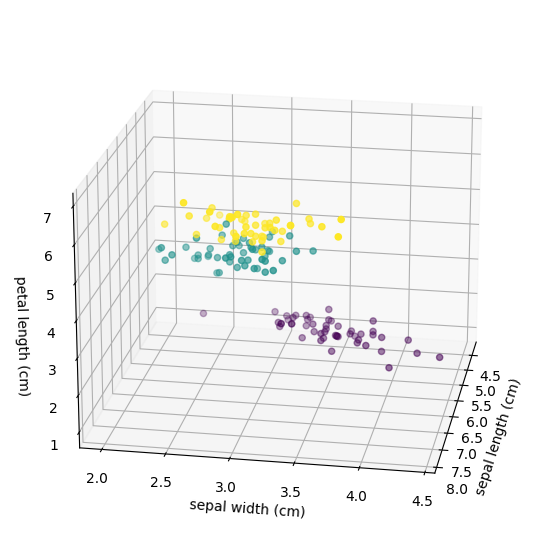

In [8]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(features[:,0], features[:,1], features[:,2], c=ext_target)
ax.set_xlabel(dataset.feature_names[0])
ax.set_ylabel(dataset.feature_names[1])
ax.set_zlabel(dataset.feature_names[2])
ax.view_init(elev=20, azim=10, roll=0)
plt.show(fig)



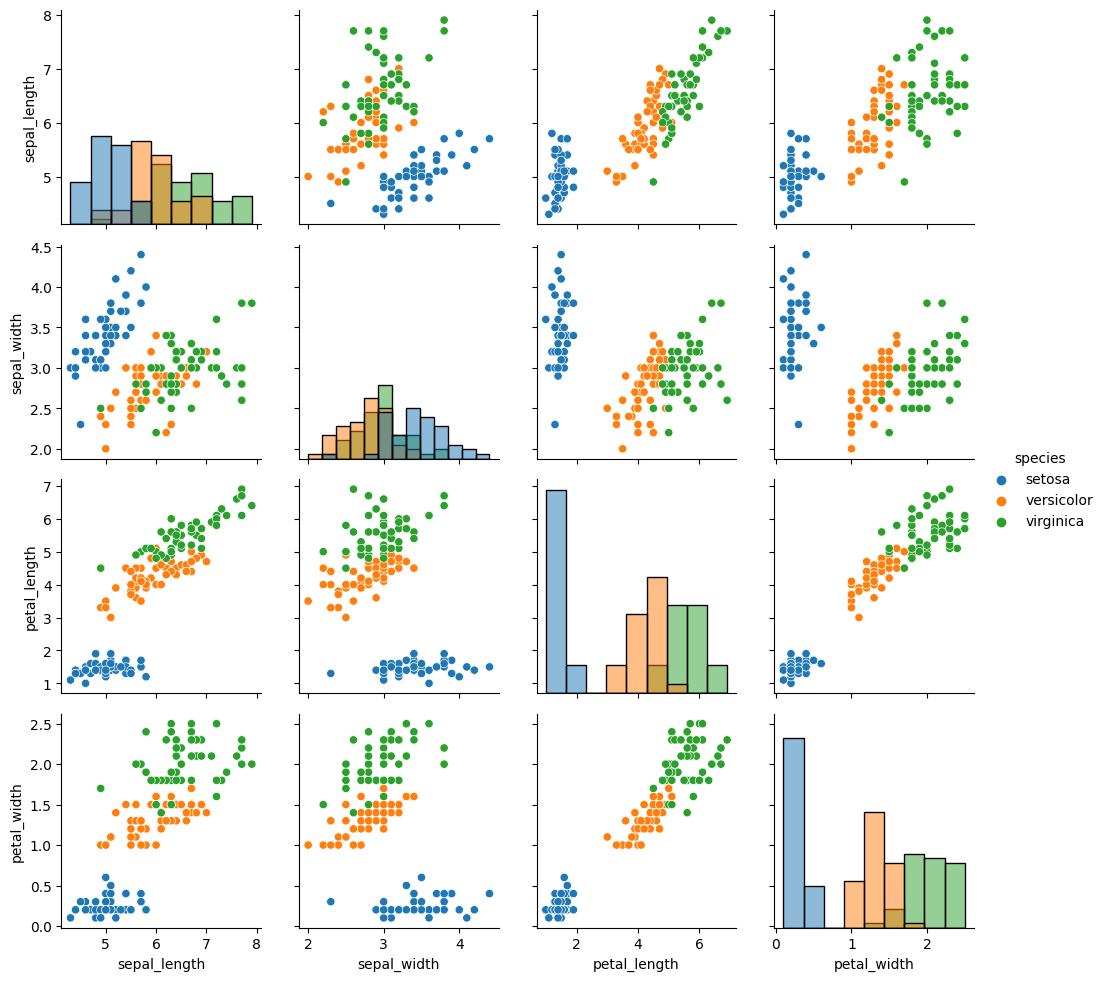

In [9]:
iris = sns.load_dataset("iris")
g = sns.PairGrid(iris, hue='species')
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.scatterplot)
g.add_legend()

### Feature distribution

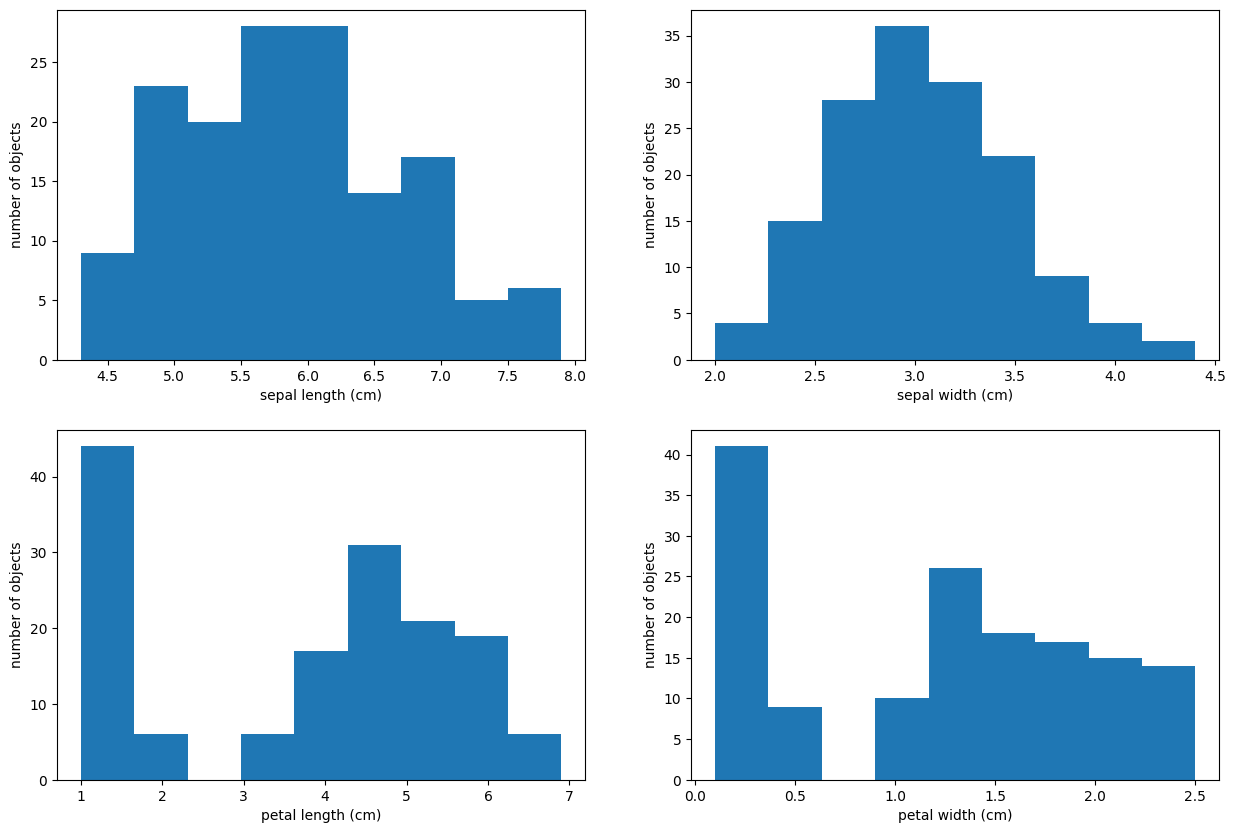

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, axis in enumerate(axes.flat):
    axis.hist(features[:, i], bins=9)
    axis.set_xlabel(dataset.feature_names[i])
    axis.set_ylabel('number of objects')

### Classifier based on the normal distribution (Gaussian Distribution)

$$
f(x, \sigma, \mu) = \frac{1}{\sqrt{2 \cdot \pi} \cdot \sigma} \cdot \exp(-\frac{(x - \mu)^2}{2 \cdot \sigma^2})
$$
After logarithm function of PDF we get following equation
$$
-0.5\cdot\log(2\cdot\pi\cdot\sigma^2) - \frac{(x - \mu)^2}{2\cdot\sigma^2}  
$$

In [11]:
class GaussianDistribution:
    def __init__(self, feature):
        """
        Args:
            feature: column of design matrix, represents all available values
            of features in axis=0 direction
        """
        self.mean = np.mean(feature, axis=0)
        self.std = np.std(feature, axis=0)


    def logpdf(self, value):
        """Logarithm of probability density function at value"""
        return -0.5 * np.log((2 * np.pi * self.std**2)) - (value - self.mean)**2 / (2 * self.std**2)

    def pdf(self, value):
        return np.exp(self.logpdf(value))

        

In [12]:
func_scipy = scipy.stats.norm(loc=features[:, :4].mean(axis=0), scale=features[:, :4].std(axis=0))
func_our = GaussianDistribution(features[:, :4])

np.allclose(func_our.logpdf(features[:10,:4]), func_our.logpdf(features[:10,:4]))

True

Bayes' theorem takes the following form:
$$
P(y_i = C_k|\mathbf{x}_i) = \frac{P(\mathbf{x}_i|y_i = C_k) P(y_i = C_k)}{P(\mathbf{x}_i)}
$$

Please note, we prefer working with log probabilities here as well. So the equation above will take the following form:
$$
\log P(y_i = C_k|\mathbf{x}_i) = \log P(\mathbf{x}_i|y_i = C_k) + \log P(y_i = C_k) - \log P(\mathbf{x}_i)
$$

The $P(\mathbf{x}_i)$ term can be computed using the following property:
$$
P(\mathbf{x}_i) = \sum_{k=1}^K P(y_i = C_k)  P(\mathbf{x}_i|y_i=C_k).
$$
It can be computed from $\log P(\mathbf{x}_i|y_i=C_k)$ values using `logsumexp` function located in `scipy.special`.m

In [13]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import logsumexp

In [14]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    
    def fit(self, X, y, sample_weight=None, distributions=None):
        
        assert sample_weight is None
        
        self.unique_labels = np.unique(y)

        # if distribution of features is not specified, than use Gaussian distribution (PDF)
        if distributions is None:
            # Create array of class object with shape = (X.shape[1],)
            distributions = [GaussianDistribution] * X.shape[1]

        else:
            # Check whether distribution are passed for all features
            assert len(distributions)==X.shape[1]

        self.conditional_feature_distribution = {}
        
        for label in self.unique_labels:
            feature_distribution = []
            for column in range(X.shape[1]):
                # for certain label form feature column array
                feature_column = X[y==label, column]
                feature_distr = distributions[column](feature_column)
                feature_distribution.append(feature_distr)
            self.conditional_feature_distribution[label] = feature_distribution

        self.prior_label_distribution = {x: np.count_nonzero(y==x) / y.size for x in self.unique_labels}

    def predict_log_proba(self, X):
        # Matrix of shape(n_objects : n_classes)
        class_log_probas = np.zeros((X.shape[0], len(self.unique_labels)), dtype=float)

        # Here we calculate the class log probabilities for each class sequntially b
        for label_ind, label in enumerate(self.unique_labels):
            for ind in range(X.shape[1]):
                # (1st term) P(xi | yi=Ck)
                class_log_probas[:, label_ind] += self.conditional_feature_distribution[label][ind].logpdf(X[:, ind])

            # add log proba of labor prior
            class_log_probas[:, label_ind] += np.log(self.prior_label_distribution[label])

        # subtract last term 3st
        for idx in range(X.shape[1]):
            class_log_probas -= logsumexp(class_log_probas, axis=1)[:, None]
        
        return class_log_probas

                

    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))

    def predict(self, X):
        log_probas = self.predict_log_proba(X)
        return np.array([self.unique_labels[idx] for idx in log_probas.argmax(axis=1)])




In [15]:
nb = NaiveBayes()
nb.fit(features, target)
print('log probas:\n{}'.format(nb.predict_log_proba(features[:2])))
print('predicted labels:\n{}'.format(nb.predict(features[:2])))
print('\nIt`s alive! More tests coming.')

log probas:
[[  0.         -41.14063634 -57.90531295]
 [  0.         -38.72865982 -56.71097942]]
predicted labels:
[0 0]

It`s alive! More tests coming.


In [16]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=24)
print(features_train.shape, features_test.shape)

(112, 4) (38, 4)


In [17]:
nb = NaiveBayes()
nb.fit(features_train, target_train, distributions=[GaussianDistribution]*4)
nb_test_log_proba = nb.predict_log_proba(features_test)


In [18]:
print('Naive Bayes classifier accuracy on the train set: {}'.format(nb.score(features_train, target_train)))

Naive Bayes classifier accuracy on the train set: 0.9642857142857143


In [19]:
print('Naive Bayes classifier accuracy on the test set: {}'.format(nb.score(features_test, target_test)))

Naive Bayes classifier accuracy on the test set: 0.9473684210526315


In [20]:
from sklearn import naive_bayes

sklearn_nb = naive_bayes.GaussianNB()
sklearn_nb.fit(features_train, target_train)
sklearn_nb_test_log_proba = sklearn_nb.predict_log_proba(features_test)

In [21]:
print('sklearn implementation accuracy on the train set: {}'.format(sklearn_nb.score(features_train, target_train)))

sklearn implementation accuracy on the train set: 0.9642857142857143


In [22]:
print('sklearn implementation accuracy on the test set: {}'.format(sklearn_nb.score(features_test, target_test)))

sklearn implementation accuracy on the test set: 0.9473684210526315


In [23]:
assert np.allclose(nb_test_log_proba, sklearn_nb_test_log_proba), 'log probabilities do not match'
print('Seems alright!')

Seems alright!


In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(features_train, target_train)
knn.score(features_train, target_train)

0.9642857142857143

In [25]:
knn.score(features_test, target_test)

0.9736842105263158

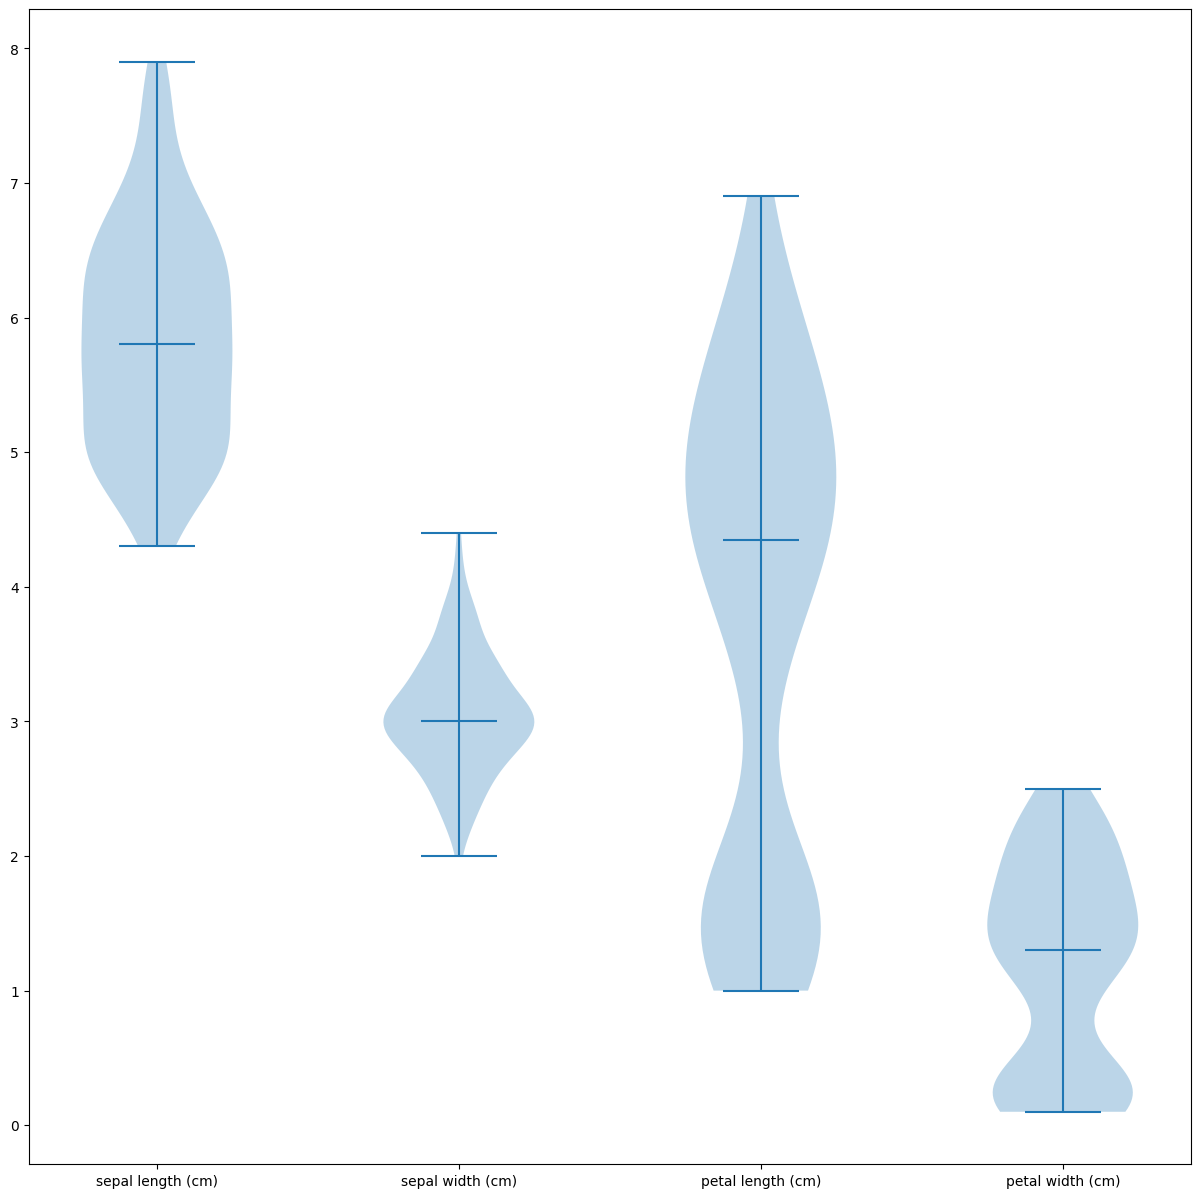

In [26]:
labels = df.columns[:4]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15), sharey=True)
plt.violinplot(features, showmedians=True)
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels)
plt.show()

Text(0, 0.5, 'probability')

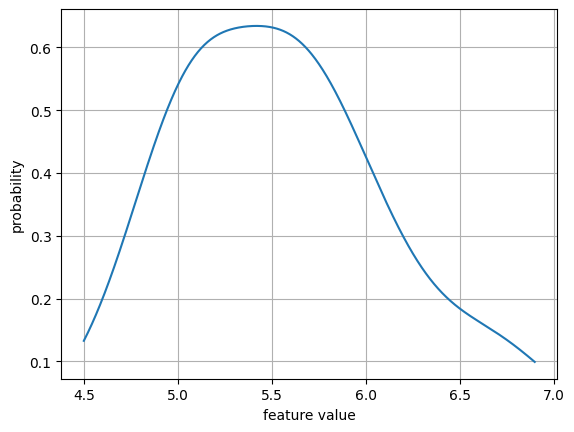

In [27]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.28, kernel='gaussian')
feature_col = features[target==2, 2]
kde.fit(feature_col.reshape((-1, 1)))
linspace = np.linspace(feature_col.min(), feature_col.max(), 1000)
plt.plot(linspace, np.exp(kde.score_samples(linspace.reshape((-1, 1)))))
plt.grid()
plt.xlabel('feature value')
plt.ylabel('probability')

In [28]:
class GaussianKDE:
    def __init__(self, feature):
        self.kde = KernelDensity(bandwidth=0.1)
        self.kde.fit(feature.reshape((-1,1)))
    
    def logpdf(self, value):
        return self.kde.score_samples(value.reshape((-1, 1)))
        

    def pdf(self, value):
        #return np.exp(self.logpdf(self, value))
        return np.exp(self.log_proba(value))
        

In [29]:
nb_kde = NaiveBayes()
nb_kde.fit(features, target, distributions=[GaussianKDE]*4)
print('log probas:\n{}'.format(nb_kde.predict_log_proba(features[:2])))
print('predicted labels:\n{}'.format(nb_kde.predict(features[:2])))
print('\nIt`s alive!')


log probas:
[[   0.         -169.49179746 -565.93727936]
 [   0.         -166.21989429 -561.39461672]]
predicted labels:
[0 0]

It`s alive!


In [30]:
print('KDE Naive Bayes classifier accuracy on the train set: {}'.format(nb_kde.score(features_train, target_train)))

KDE Naive Bayes classifier accuracy on the train set: 0.9642857142857143


In [31]:
print('KDE Naive Bayes classifier accuracy on the test set: {}'.format(nb_kde.score(features_test, target_test)))

KDE Naive Bayes classifier accuracy on the test set: 0.9736842105263158


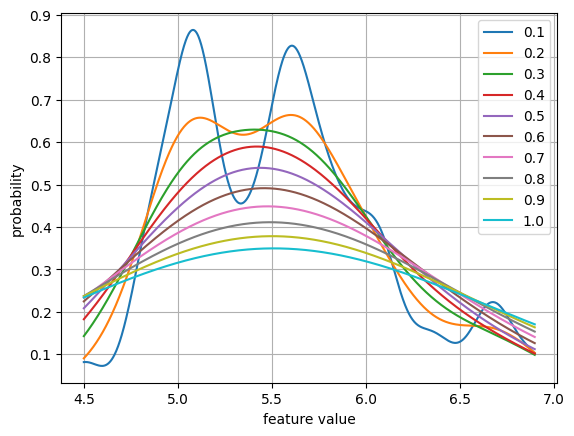

In [32]:
bw = np.linspace(0.1, 1.0, 10, dtype=np.float16)


for i in bw:
    #print(i)
    kde = KernelDensity(bandwidth=i, kernel='gaussian')
    feature_col = features[target==2, 2]
    kde.fit(feature_col.reshape((-1, 1)))
    linspace = np.linspace(feature_col.min(), feature_col.max(), 1000)
    plt.plot(linspace, np.exp(kde.score_samples(linspace.reshape((-1, 1)))))
    
plt.grid()
plt.xlabel('feature value')
plt.ylabel('probability')
plt.legend(bw)
    

,train,test
0,0.964286,0.973684
1,0.964286,0.973684
2,0.964286,0.973684
3,0.964286,0.973684
4,0.964286,0.973684
5,0.964286,0.973684
6,0.964286,0.973684
7,0.964286,0.973684
8,0.964286,0.973684
9,0.964286,0.973684


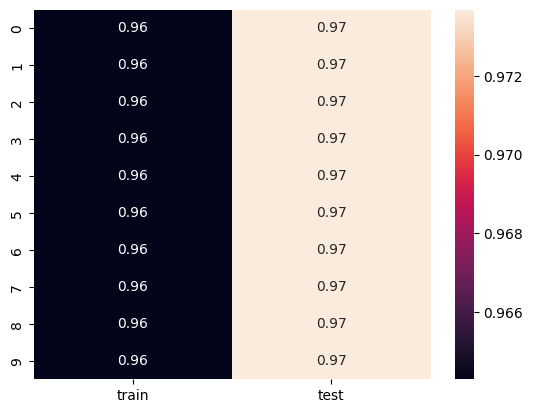

In [33]:
bwd = {}
bwd['train'] = []
bwd['test'] = []

for i in bw:
    #print(i)
    kde = KernelDensity(bandwidth=i, kernel='gaussian')
    nb_kde = NaiveBayes()
    nb_kde.fit(features, target, distributions=[GaussianKDE]*4)
    bwd['train'].append(nb_kde.score(features_train, target_train))
    bwd['test'].append(nb_kde.score(features_test, target_test))

df = pd.DataFrame(bwd)
sns.heatmap(df, annot=True)
df

In [34]:
class GaussianKDE:
    def __init__(self, feature):
        self.kde = KernelDensity(bandwidth=1.)
        self.kde.fit(feature.reshape((-1, 1)))

    def logpdf(self, value):
        return self.kde.score_samples(value.reshape((-1, 1)))

    def pdf(self, value):
        return np.exp(self.log_proba(value))

nb_kde = NaiveBayes()
nb_kde.fit(features, target, distributions=[GaussianKDE]*4)



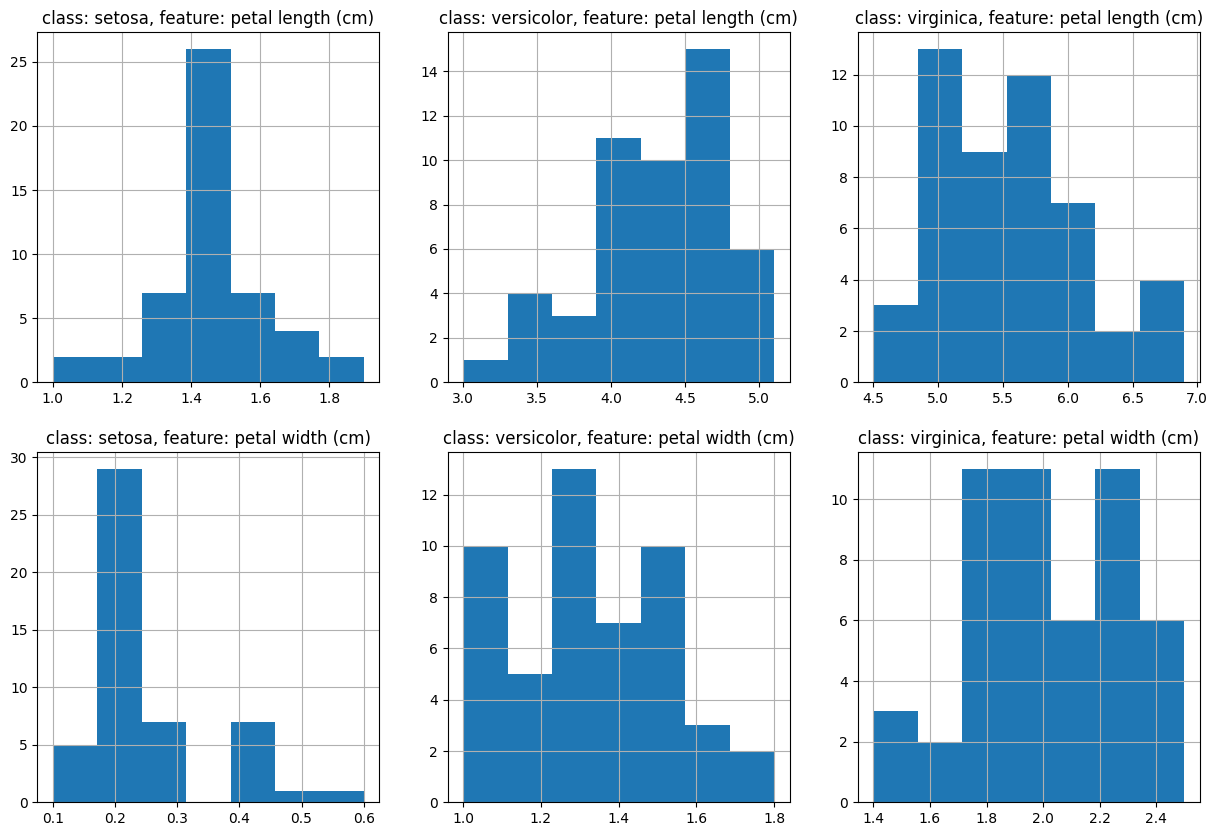

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        ax.hist(feature_col, bins=7)
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]))

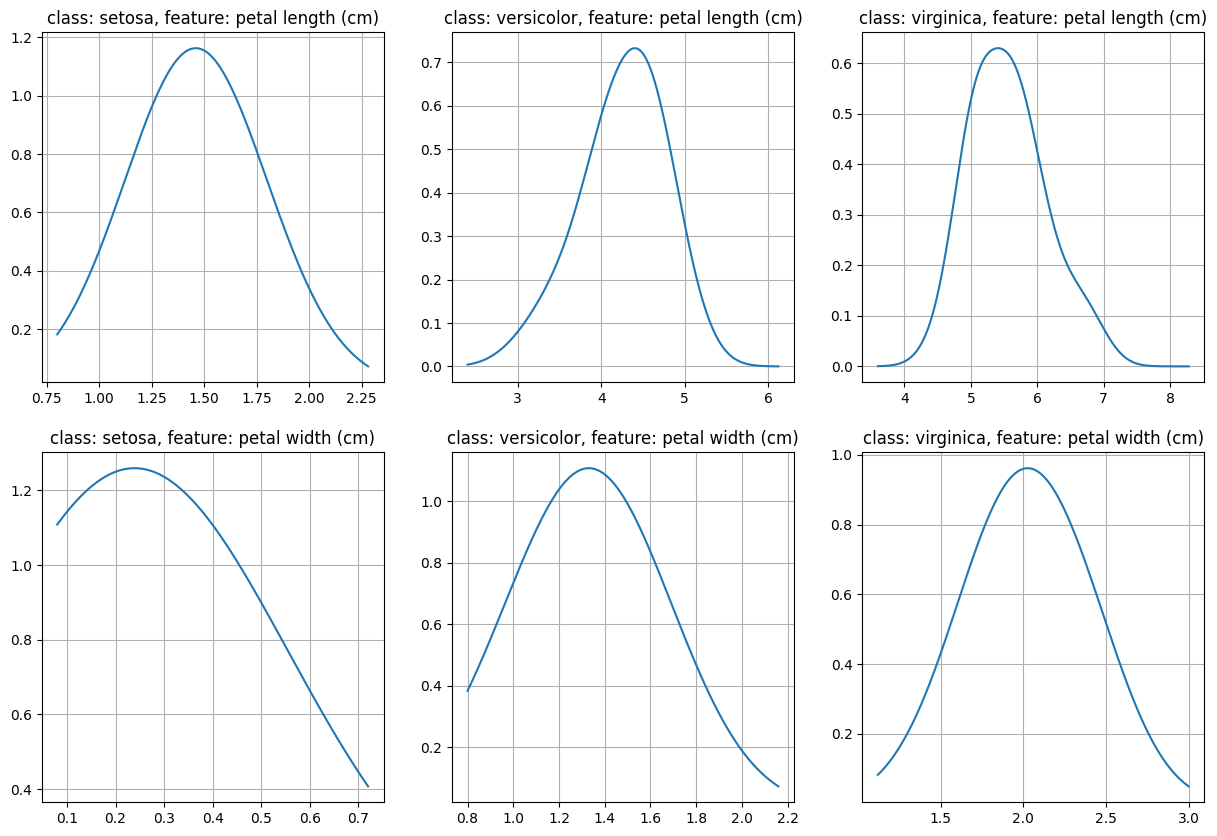

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
kde = KernelDensity(bandwidth=0.3, kernel='gaussian')

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        kde.fit(feature_col.reshape((-1, 1)))
        linspace = np.linspace(
            0.8*feature_col.min(),
            1.2*feature_col.max(),
            1000
        )
        ax.plot(linspace, np.exp(kde.score_samples(linspace.reshape((-1, 1)))))
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]
        ))

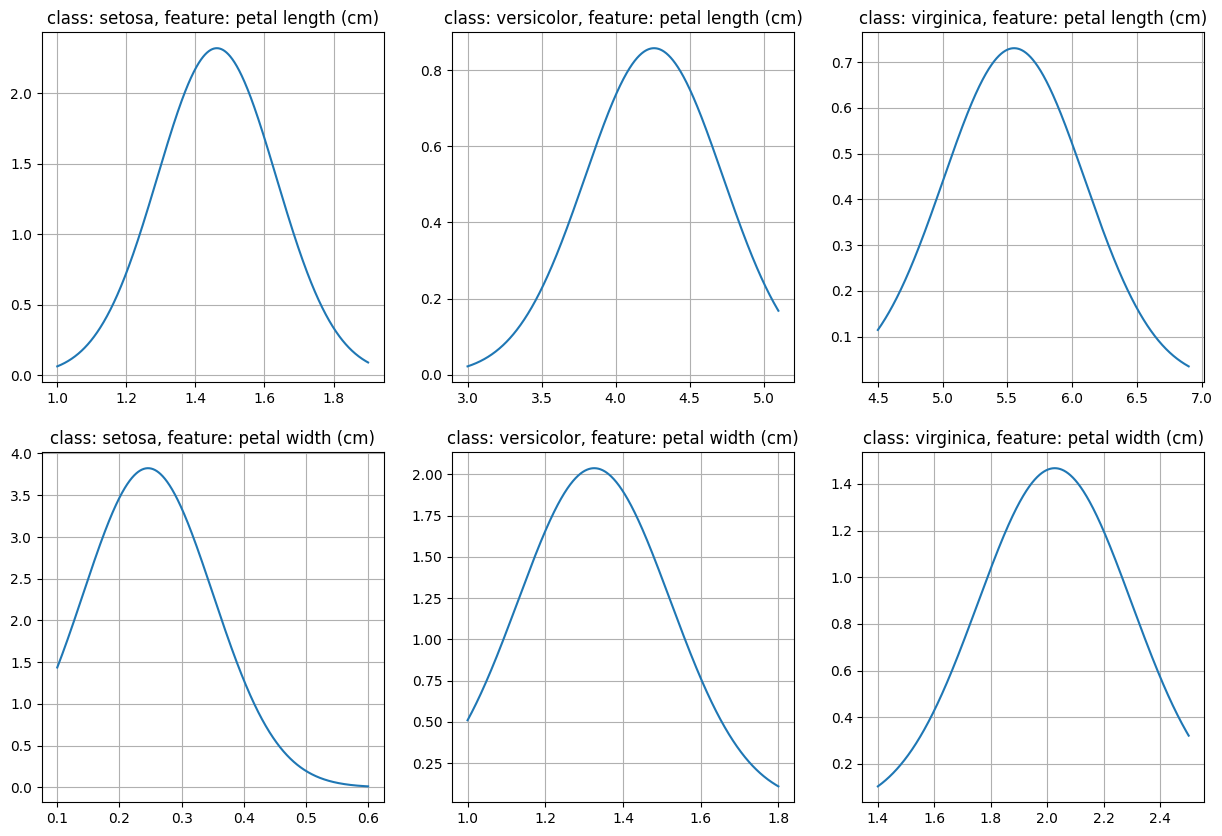

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        gaussian_distr = GaussianDistribution(feature_col)
        linspace = np.linspace(
            feature_col.min(),
            feature_col.max(),
            1000
        )
        ax.plot(linspace, gaussian_distr.pdf(linspace.reshape((-1, 1))))
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]
        ))

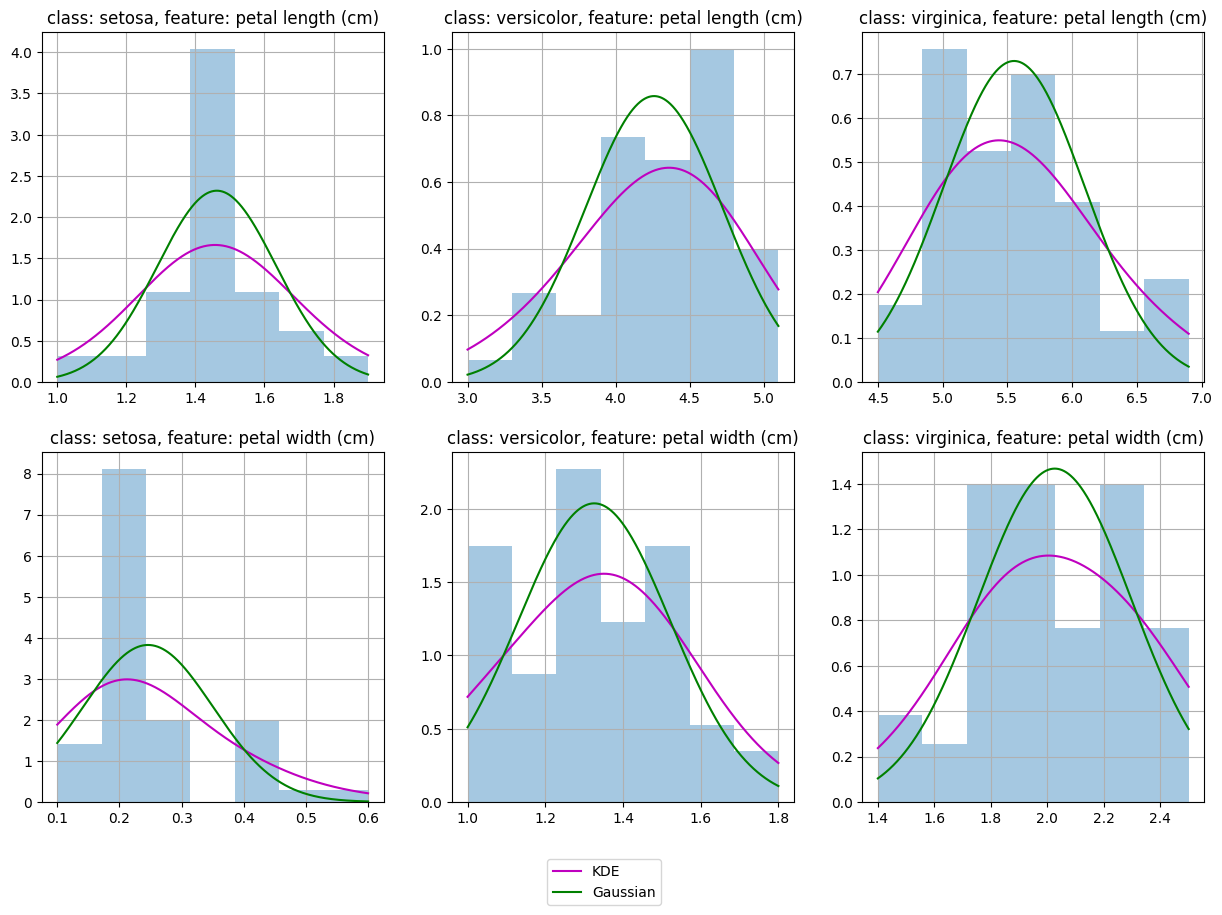

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        ax.hist(feature_col, bins=7, density=True, alpha=0.4)
                
        bandwidth = abs((feature_col.min() - feature_col.max()) / 5)
        kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
        kde.fit(feature_col.reshape((-1, 1)))
        linspace = np.linspace(
            feature_col.min(),
            feature_col.max(),
            1000
        )
        ax.plot(linspace, np.exp(kde.score_samples(linspace.reshape((-1, 1)))), c='m', label='KDE')
        
        gaussian_distr = GaussianDistribution(feature_col)
        # linspace = np.linspace(
        #     feature_col.min(),
        #     feature_col.max(),
        #     1000
        # )
        ax.plot(linspace, gaussian_distr.pdf(linspace.reshape((-1, 1))), c='g', label='Gaussian')        
        
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]
        ))

labels_handles = {
  label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}
fig.legend(
  labels_handles.values(),
  labels_handles.keys(),
  loc="lower center",
  bbox_to_anchor=(0.5, 0),
  bbox_transform=plt.gcf().transFigure,
)